## Fake News Detection

This kernel will walk through basic usage of an LSTM neural network in order to perform fake news detection.

In [ ]:
import os
from functools import partial
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

##### First, let's view the data

In [2]:
data = pd.read_csv("fake-news/train.csv")
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


##### The data needs to be checked for missing values.

In [3]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

##### Drop the missing values and check the dataframe again.

In [4]:
data.dropna(inplace=True)
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

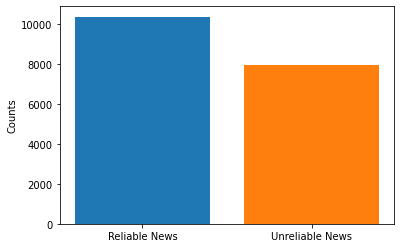

In [5]:
real_news = data[data["label"]==0].values
fake_news = data[data["label"]==1].values
plt.bar(0,height=len(real_news))
plt.bar(1,height=len(fake_news))
plt.xticks([0,1],["Reliable News","Unreliable News"])
plt.ylabel("Counts")
plt.show()

### Build a Pytorch Dataset.

The data has several fields that could be used for prediction. However, since titles often exaggerate the truth to catch the reader's attention, only the text of the news article will be utilized. 

In [6]:
class MyDataset(Dataset):
    def __init__(self, ds):
        super(MyDataset,self).__init__()
        self.labels = ds["label"].values
        self.data = ds["text"].values

    def __getitem__(self, idx):
        # load data and labels
        labels = self.labels[idx]
        data = self.data[idx]
        return labels, data

    def __len__(self):
        return len(self.data)

##### Print the label and the first 50 words for the first entry in the dataset.

In [7]:
ds = MyDataset(data)
label, text = next(iter(ds))
label, text[:50]

(1, 'House Dem Aide: We Didn’t Even See Comey’s Letter ')

##### Build the vocabulary list.

In [8]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter,tokenizer):
    for _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(ds,tokenizer))

In [9]:
def text_pipeline(text,vocab,tokenizer):
    tokens = tokenizer(text)
    vocab_list = []
    for t in tokens:
        vocab_list.append(vocab[t])
    return vocab_list

text_pipeline = partial(text_pipeline,vocab=vocab,tokenizer=tokenizer)

#### Test the text pipeline
A list/array of words can be fed into the text pipeline to return the index of that word in the vocab list. Words not contained in the vocabulary list return an index of 0.

In [10]:
_, text = next(iter(ds))
text_pipeline(text)[:5]

[128, 5754, 2282, 42, 360]

##### The data should be checked for a distribution of the sequence lengths

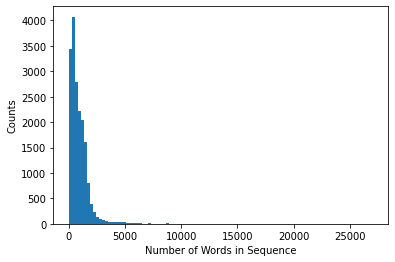

In [11]:
ds_iter = iter(ds)
all_ds_lengths = []
for d in ds_iter:
    _, text = d
    all_ds_lengths.append(len(text_pipeline(text)))

plt.hist(all_ds_lengths,100)
plt.xlabel("Number of Words in Sequence")
plt.ylabel("Counts")
plt.show()

### The maximum sequence length could be set at 2,500 words without affecting too much of the data.

An argument could also be given about how the gist of an article could be resolved in fewer than 2,500 words. A transformation function needs to be written to implement this.

In [12]:
def collate_batch(batch,text_pipeline,max_seq_len,device):
    data = torch.zeros((len(batch),max_seq_len),dtype=torch.int64)
    labels = torch.zeros((len(batch)),dtype=torch.int64)
    for index,data_tuple in enumerate(batch):
        processed_text = torch.tensor(text_pipeline(data_tuple[1]), dtype=torch.int64)
        data[index,:len(processed_text)] = processed_text[:max_seq_len]
        labels[index] = data_tuple[0]
    return labels.to(device), data.to(device)

max_seq_len = 1000
col_fn = partial(collate_batch,text_pipeline=text_pipeline,max_seq_len=max_seq_len,device=device)

#### Create the LSTM model
The embedding layer turns the vectorized text into dense vectors where related words will have a higher similarity to each other. The similarity between words becomes a useful feature vector, and helps the neural network make predictions.

The LSTM (Long Short-Term Memory) is a special type of RNN (Recurrent Neural Network) that circumvents the "vanishing" or "exploding" gradient problem seen by RNNs.

Finally the fully-connected layer outputs values which are used to predict the truth of the text read by the neural network.

In [13]:
class NewsPrediction(torch.nn.Module):
    def __init__(self,vocab_length,embedding_dim,seq_len,num_layers,num_hidden):
        super(NewsPrediction,self).__init__()
        self.embedding = nn.Embedding(vocab_length,embedding_dim,max_norm=True)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=num_hidden,num_layers=num_layers,batch_first=True)
        self.fc = nn.Linear(seq_len*num_hidden,2)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.reshape(x, (x.size(0),-1,))
        x = self.fc(x)
        return F.log_softmax(x,dim=-1)

##### Initialize the model and create an iterable dataset

In [14]:
batch_size = 512
model = NewsPrediction(len(vocab),embedding_dim=32,seq_len=max_seq_len,num_layers=1,num_hidden=32)
model.to(device)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=0,collate_fn=col_fn)

##### Set the optimization algorithm, loss function, and split the dataset into training and validation

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters())

num_train = int(len(dl)*0.8)
num_valid = len(dl) - num_train
training_data, validation_data = random_split(dl, [num_train,num_valid])
datasets = {"Training":training_data.dataset, "Validation":validation_data.dataset}

In [ ]:
num_epoch = 10
weights_path = r"../input/fake-news/model_weights.pt"
val_losses = [np.inf]
no_improvement = 0
for epoch in range(num_epoch):
    for d in datasets:
        if d == "Training":
            model.train(True)
        else:
            model.train(False)
        dataset = datasets[d]
        total_pts = 0
        running_loss, running_acc = 0.0, 0.0
        for i, sample in enumerate(dataset):
            labels,data = sample
            optimizer.zero_grad()
            out = model(data)
            _, pred = torch.max(out, 1)
            num_correct = (pred == labels).sum()
            loss = criterion(out,labels)
            if d == "Training":
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
            running_acc  += num_correct.data.item()
            total_pts += len(sample[0])

        print("Epoch {}, {} Loss: {}, Accuracy: {}".format(epoch + 1, d, running_loss / i, running_acc / total_pts * 100))
        if d == "Validation":
            val_loss = running_loss / i
            if all(val_losses < np.array(val_loss)):
                torch.save(model.state_dict(),weights_path)
                no_improvement = 0
            else:
                no_improvement += 1
            val_losses.append(val_loss)
            if no_improvement == 3:
                break